In [1]:
library(reticulate)
library(plyr)
library(tidyr)
library(dplyr)
library(DALEX)
library(ggplot2)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Welcome to DALEX (version: 2.2.0).
Find examples and detailed introduction at: http://ema.drwhy.ai/
Additional features will be available after installation of: ggpubr.
Use 'install_dependencies()' to get all suggested dependencies


Attaching package: ‘DALEX’


The following object is masked from ‘package:dplyr’:

    explain




In [25]:
install.packages('ceterisParibus')

Installing package into ‘/home/llaszczuk/R/x86_64-pc-linux-gnu-library/4.0’
(as ‘lib’ is unspecified)

also installing the dependency ‘gower’




In [62]:
library(ingredients)


Attaching package: ‘ingredients’


The following objects are masked from ‘package:ceterisParibus’:

    calculate_oscillations, ceteris_paribus, select_neighbours,
    select_sample


The following object is masked from ‘package:DALEX’:

    feature_importance




In [2]:
use_condaenv('analiza_dyfuzji', required = TRUE)
source_python('utils.py')
os <- import('os')

In [3]:
model <- load_model('Models/model_hanna_2d.sav')

In [4]:
data <- load_data('Data/characteristics/characteristics_h.csv', 1/6)

In [5]:
class_vector <- unlist(CLASS_MAPPING, use.names = FALSE)

In [6]:
x_train <- data[[1]]
x_test <- data[[2]]
y_train <- data[[3]]
y_test <- data[[4]]

### Create explainer

In [7]:
explainer <- explain(model,
       data=x_train,
       y=y_train,
       label='Model',
       predict_function=custom_predict,
       residual_function=custom_residual_function)

Preparation of a new explainer is initiated
  -> model label       :  Model 
  -> data              :  52520  rows  17  cols 
  -> target variable   :  52520  values 
  -> predict function  : 'predict_function' is not a 'function' class object! (  WARNING  )
  -> predict function  :  custom_predict 
  -> predicted values  :  No value for predict function target column. (  default  )
  -> model_info        :  package Model of class: sklearn.ensemble._gb.GradientBoostingClassifier package unrecognized , ver. Unknown , task regression (  default  ) 
  -> predicted values  :  predict function returns multiple columns:  5  (  default  ) 
  -> residual function : 'residual_function' is not a 'function' class object! (  WARNING  )
  -> residual function :  custom_residual_function 
  -> residuals         :  the residual_function returns an error when executed (  WARNING  ) 
  A new explainer has been created!  


In [75]:
THEME_CUSTOM <- theme(plot.title = element_text(size = 20, hjust = 0.5, face = "bold"),
                      text = element_text(face = "bold"),
                      legend.text = element_text(size = 11, face = "bold"),
                      legend.position = "bottom",
                      legend.key.width = unit(1, "cm"),
                      strip.background = element_rect(color = "black", fill = "white", size = 1, linetype = "solid"))


In [185]:
create_bd_plot <- function(explainer, x){
    bd <- predict_parts(explainer, x, type='break_down', N=500)
    bd$label <- mapvalues(bd$label, from=c(unique(bd$label)), to=unlist(CLASS_MAPPING, use.names = FALSE))
    bd
}

save_plot <- function(path, bd, height=20, width=8, max_features=17){
    plt <- plot(bd, max_features=max_features)
    pdf(path, height=height, width=width)
    print(plt)
    dev.off()
}

create_cpp_plot <- function(explainer, x, variables){
    cpp <- ingredients::ceteris_paribus(explainer, x, variables = variables)
    cpp <- correct_labels_cpp(cpp)
    cpp$`_label_` <- mapvalues(cpp$`_label_`, from=c(unique(cpp$`_label_`)), to=unlist(CLASS_MAPPING, use.names = FALSE))
    cpp

}

create_pdp_plot <- function(explainer, variables){
    cpp <- ingredients::partial_dependency(explainer, variables = variables)
    cpp <- correct_labels_cpp(cpp)
    cpp$`_label_` <- mapvalues(cpp$`_label_`, from=c(unique(cpp$`_label_`)), to=unlist(CLASS_MAPPING, use.names = FALSE))
    cpp

}

In [186]:
correct_labels_cpp <- function(cpp_profile) {
  split_names_vector <- unlist(strsplit(cpp_profile$`_label_`, 'Model.'))
  cpp_profile$`_label_` <- split_names_vector[seq(2, length(split_names_vector), 2)]
  return(cpp_profile)
}

In [187]:
pdp <- create_pdp_plot(explainer, variables=c('alpha'))

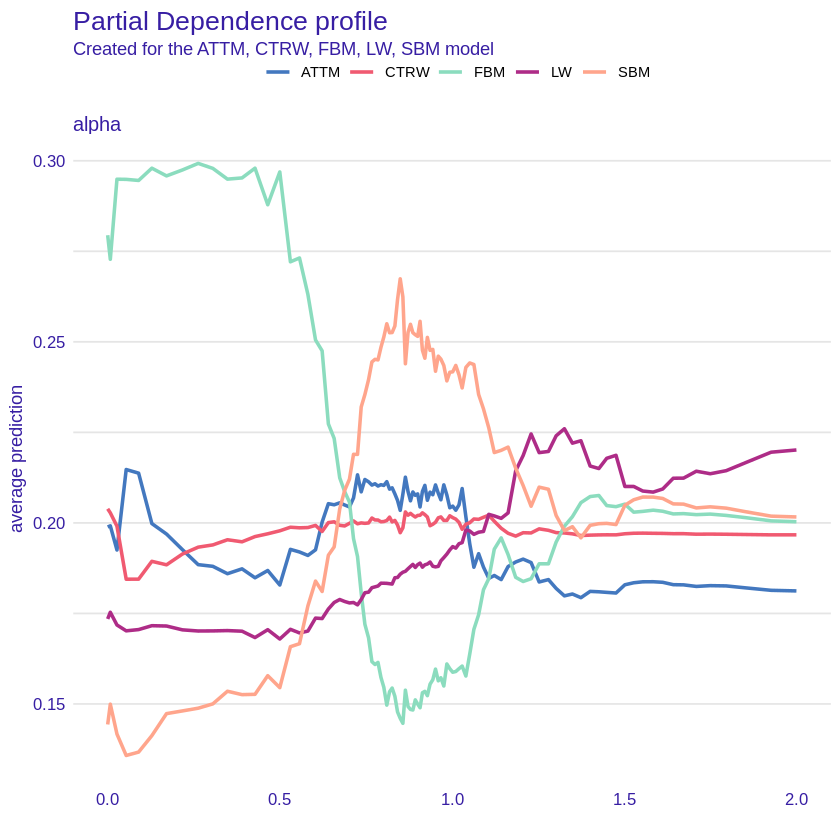

In [191]:
plot(pdp)

In [160]:
cpp <- create_cpp_plot(explainer, x_test_bd[1, 1:17], variables = c('alpha'))

In [174]:
plot_cpp <- function(cpp_result){
    plot(cpp, color = '_label_', show_observations = FALSE) +
  ggtitle("Ceteris-paribus profile", "") + ylim(0, 1)+ 
labs(y='Prediction', x='Variable value') +
scale_color_manual(guide = "legend", name = "Legend", values = c("ATTM" = "#d96c06", "CTRW" = "blue", 
                                                                "FBM" = "green", "LW" = "red",
                                                                "SBM" = "black"))
}

In [176]:
save_cpp_plot <- function(path, cpp_plot, height=20, width=8){
    pdf(path, height=height, width=width)
    print(cpp_plot)
    dev.off()
}

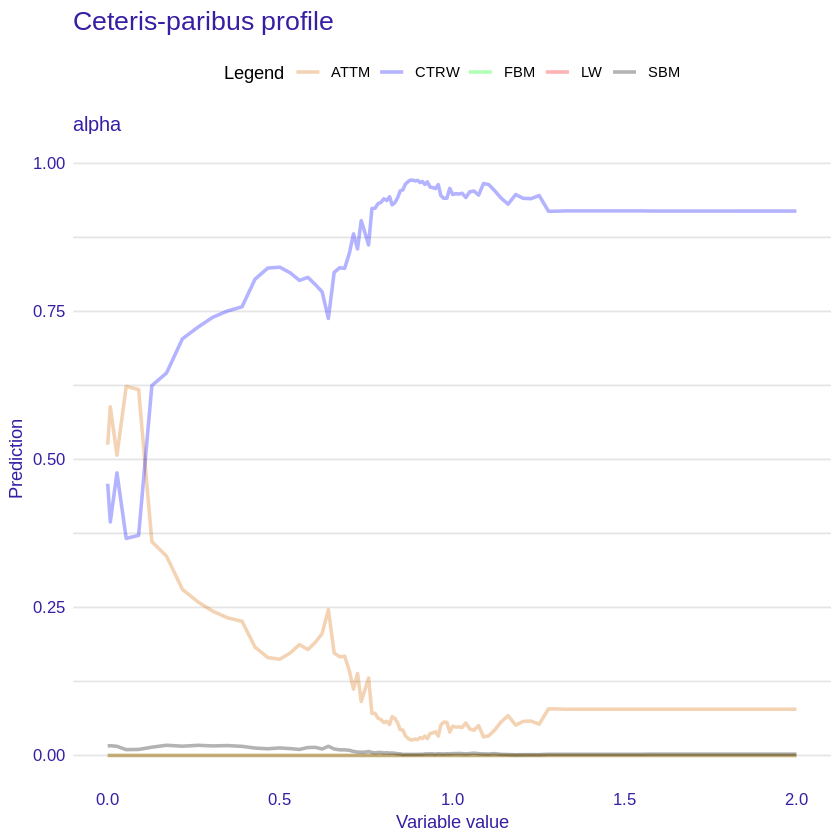

In [165]:
plot_cpp(cpp)

In [ ]:
create_bd_plot <- function(explainer, x){
    bd <- predict_parts(explainer, x, type='break_down', N=500)
    bd$label <- mapvalues(bd$label, from=c(unique(bd$label)), to=unlist(CLASS_MAPPING, use.names = FALSE))
    bd
}

## Proces:
1. Dokonaj predykcji na zbiorze testowym;
2. Wybierz obserwacje o danym błędzie;
3. Wykonaj funkcję tworzącą bd-plot oraz dodaj wyniki do DF;
4. Zapisz wykres.

Funkcja podsumowująca:

Dla każdego z najczęstszych błędów i każdej cechy:

1. Rozkład cechy (na całym zbiorze);
2. Punktami zaznacz wartości cech, dla których występowały błędy, kolorem zaznacz wartości break-down;
3. Sprawdź średnie wartości break-down każdej z cech

### Predykcje na zbiorze testowym:

In [9]:
y_pred <- model$predict(x_test)

In [10]:
n_cols <- ncol(x_test)
df_predictions <- data.frame(y_real=y_test, y_pred=y_pred)
x_test_bd <- cbind(x_test, df_predictions)

In [11]:
# Real vs Pred.
common_mistakes <- list(attm_sbm=c(0, 4),
                        attm_ctrw=c(0, 1),
                        fbm_sbm=c(2, 4))

### Wybranie obserwacji, bd-plot

In [ ]:
df <- data.frame()
for(el in common_mistakes){
    df_sub <- x_test_bd %>% filter(y_real==el[1],
                                   y_pred==el[2])
    df_sub <- df_sub[, 1:n_cols]
    for(row in 1:300){
        res <- create_bd_plot(explainer, df_sub[row, ])
        save_plot(os$path$join('Explanation',
                               'h',
                               'local',
                               'break_down',
                               paste0(class_vector[el[1]+1], '_', class_vector[el[2]+1]),
                                      paste0(row, '.pdf')),
                 res)
        to_spread <- res[(el[2]*(n_cols+2)+1):((el[2]+1)*(n_cols+2)), c(2, 3, 4)]
        to_add <- to_spread %>% pivot_wider(names_from='variable_name', values_from=c('contribution','variable_value'))
        to_add[, 'predicted_class'] <- el[2]
        to_add[, 'real_class'] <- el[1]
        df <- rbind(df, to_add)
        
    }
}

In [ ]:
write.csv(df, os$path$join('Data', 'break-down-values.csv'))

## Ceteris paribus profile

In [180]:
df <- data.frame()
for(el in common_mistakes){
    df_sub <- x_test_bd %>% filter(y_real==el[1],
                                   y_pred==el[2])
    df_sub <- df_sub[, 1:n_cols]
    for(row in 1:300){
        print(row)
        for (variable in c('fractal_dimension', 'mean_gaussianity',
                          'p_var_2', 'p_var_3', 'p_var_5')){
            
        cpp <- create_cpp_plot(explainer, df_sub[row, ], variables = c(variable))
            res <- plot_cpp(cpp)
        
        save_cpp_plot(os$path$join('Explanation',
                               'h',
                               'local',
                               'ceteris_paribus',                                   
                               paste0(class_vector[el[1]+1], '_', class_vector[el[2]+1]),
                                   variable,
                                      paste0(row, '.pdf')), cpp_plot=res,
                     width=10, height=8)
        }
    }
}

[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15
[1] 16
[1] 17
[1] 18
[1] 19
[1] 20
[1] 21
[1] 22
[1] 23
[1] 24
[1] 25
[1] 26
[1] 27
[1] 28
[1] 29
[1] 30
[1] 31
[1] 32
[1] 33
[1] 34
[1] 35
[1] 36
[1] 37
[1] 38
[1] 39
[1] 40
[1] 41
[1] 42
[1] 43
[1] 44
[1] 45
[1] 46
[1] 47
[1] 48
[1] 49
[1] 50
[1] 51
[1] 52
[1] 53
[1] 54
[1] 55
[1] 56
[1] 57
[1] 58
[1] 59
[1] 60
[1] 61
[1] 62
[1] 63
[1] 64
[1] 65
[1] 66
[1] 67
[1] 68
[1] 69
[1] 70
[1] 71
[1] 72
[1] 73
[1] 74
[1] 75
[1] 76
[1] 77
[1] 78
[1] 79
[1] 80
[1] 81
[1] 82
[1] 83
[1] 84
[1] 85
[1] 86
[1] 87
[1] 88
[1] 89
[1] 90
[1] 91
[1] 92
[1] 93
[1] 94
[1] 95
[1] 96
[1] 97
[1] 98
[1] 99
[1] 100
[1] 101
[1] 102
[1] 103
[1] 104
[1] 105
[1] 106
[1] 107
[1] 108
[1] 109
[1] 110
[1] 111
[1] 112
[1] 113
[1] 114
[1] 115
[1] 116
[1] 117
[1] 118
[1] 119
[1] 120
[1] 121
[1] 122
[1] 123
[1] 124
[1] 125
[1] 126
[1] 127
[1] 128
[1] 129
[1] 130
[1] 131
[1] 132
[1] 133
[1] 134
[1] 135
[1] 136
[1] 137
[1] 138
[1] 

## PDP

In [204]:
c(unlist(colnames(x_test)))

[1] "D"                               "alpha"                          
 [3] "alpha_n_1"                       "alpha_n_2"                      
 [5] "alpha_n_3"                       "fractal_dimension"              
 [7] "mean_gaussianity"                "mean_squared_displacement_ratio"
 [9] "straightness"                    "p-variation"                    
[11] "max_excursion_normalised"        "vac_lag_1"                      
[13] "p_var_1"                         "p_var_2"                        
[15] "p_var_3"                         "p_var_4"                        
[17] "p_var_5"

In [202]:
for(el in common_mistakes){

        for (variable in unlist(colnames(x_test))){
            
        pdp <- create_pdp_plot(explainer, variables = c(variable))
            res <- plot(pdp)
        
        save_cpp_plot(os$path$join('Explanation',
                               'h',
                               'local',
                               'partial_dependency',                                   
                               paste0(class_vector[el[1]+1], '_', class_vector[el[2]+1]),
                                   
                                      paste0(variable, '.pdf')), cpp_plot=res,
                     width=10, height=8)
        }
    
}